## Content
- The dataset is a CSV, where each row is a tweet. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

### tweet_id
- A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

### author_id
- A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

### inbound
- Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

### created_at
- Date and time when the tweet was sent.

### text
- Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.

### response_tweet_id
- IDs of tweets that are responses to this tweet, comma-separated.

### in_response_to_tweet_id
- ID of the tweet this tweet is in response to, if any.

## Data information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

#import findspark
#findspark.init()

#from pyspark import SparkConf
#from pyspark import SparkContext

pd.set_option('display.max_colwidth', -1)

In [0]:
#sc = SparkContext(appName="Project")

In [2]:
#Read in data
df = pd.read_csv('twcs/twcs.csv')
data = df.copy()

In [3]:
#Missing info check
data.isnull().sum()

tweet_id                   0      
author_id                  0      
inbound                    0      
created_at                 0      
text                       0      
response_tweet_id          1040629
in_response_to_tweet_id    794335 
dtype: int64

In [4]:
#checking data
data.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


Text(0, 0.5, 'Tweet Count')

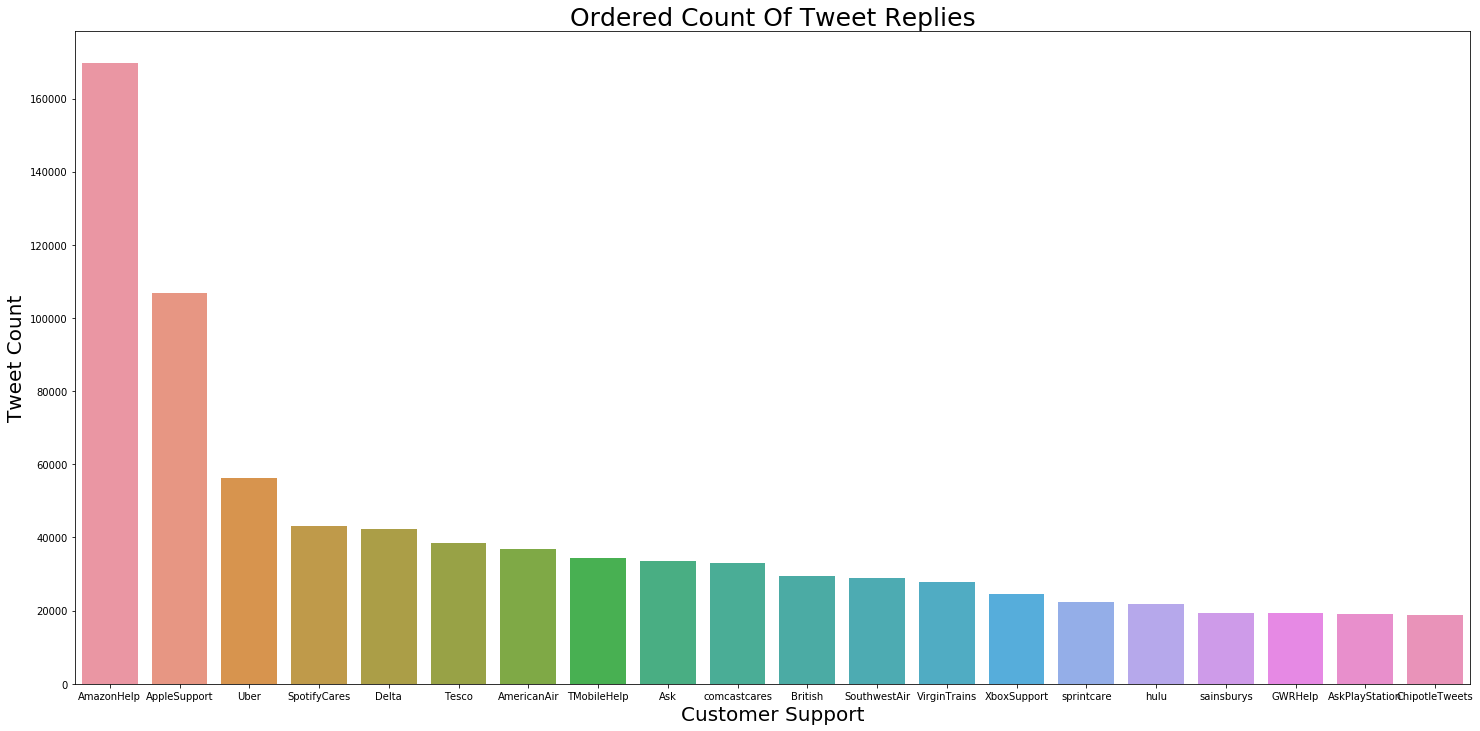

In [0]:
#Visualizing our data

#Extract the customer support company
data['customer_support_name'] = data['author_id'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

#Take 20 highest tweet count
count_tweet = data['tweet_id'].groupby(data['customer_support_name']).count().to_frame().reset_index()
ordered_count = count_tweet.nlargest(20, 'tweet_id')

plt.figure(figsize=(25, 12))
sns.barplot(x = ordered_count['customer_support_name'], y = ordered_count['tweet_id'])
plt.title('Ordered Count Of Tweet Replies', fontsize = 25)
plt.xlabel('Customer Support', fontsize = 20)
plt.ylabel('Tweet Count', fontsize = 20)

In [0]:
#Entire dataset's response rate including customer supports' response
print("The response rate is {} %".format(2017439 / 2811774 * 100))

The response rate is 71.74968542991009 %


In [0]:
#Cleaning up text column
words = ' '.join(data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [0]:
#Set up and generate word cloud
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

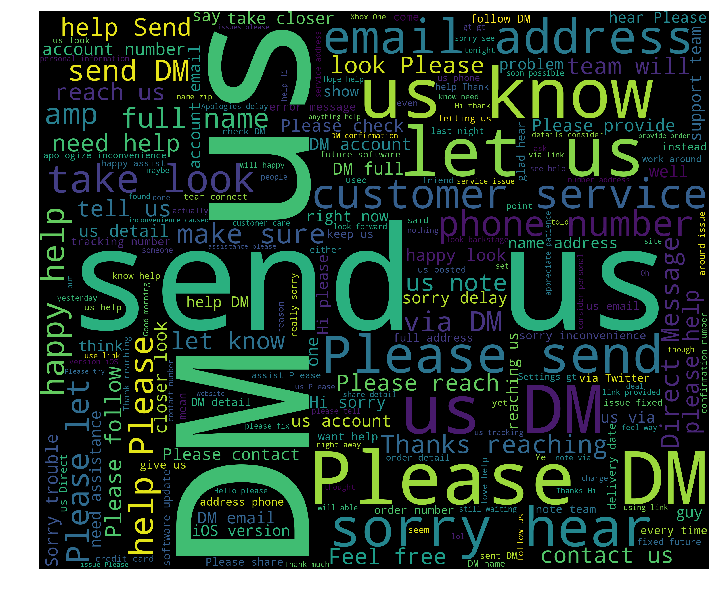

In [0]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Preprocessing Data

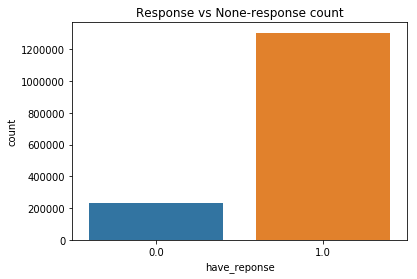

In [3]:
#Filtering out the non-customer report reply
user_tweet = data[data['author_id'].str.isdigit()]

# creating new column represents whether we have response from customer support
user_tweet.loc[user_tweet['response_tweet_id'].isnull(), 'have_reponse'] = 0
user_tweet.loc[user_tweet['have_reponse'].isnull(), 'have_reponse'] = 1

#Vivualize the reponse vs non-response data
sns.countplot(user_tweet['have_reponse'])
plt.title("Response vs None-response count")
plt.show()

In [4]:
user_tweet.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,have_reponse
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,0.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0,1.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,1.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0,1.0


In [55]:
#Take out the stop words, stem and lemmatize
stop_words = set(stopwords.words('english'))
stop_words.add('u')
#wordnet_lemmatizer = WordNetLemmatizer()
#porter = PorterStemmer()

def normalizer(tweet):
    tweet = " ".join([word for word in tweet.split() if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    #stemmed = list(porter.stem(word) for word in filtered_result)
    lemmas = " ".join(t for t in filtered_result)#wordnet_lemmatizer.lemmatize(t) for t in stemmed)
    return lemmas

In [56]:
normalizer("@115714 whenever I contact customer support, they tell me I have shortcode enabled on my account, \
           but I have never in the 4 years I've tried https://t.co/0G98RtNxPK.")

'whenever contact customer support tell shortcode enabled account never years tried'

In [57]:
#Normalize the text column
user_tweet['normalized_tweet'] = user_tweet.text.apply(normalizer)

In [58]:
#Count of word prequencies
word_frequency_count = user_tweet.normalized_tweet.str.split(expand=True).stack().value_counts()

In [59]:
#Top 10 normalized word count
word_frequency_count[0:10]

get        118127
service    87825 
thanks     85857 
help       84877 
please     80569 
time       72886 
phone      69368 
one        69080 
still      68991 
amp        58211 
dtype: int64

In [60]:
#Feature engineering adding length of twitter as input
user_tweet['tweet_length']=user_tweet['text'].apply(lambda x: len(x))

In [61]:
user_tweet.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,have_reponse,normalized_tweet,tweet_length
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,0.0,propose,45
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0,1.0,sent several private messages one responding usual,82
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1.0,,18
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,1.0,worst customer service,41
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0,1.0,gon na magically change connectivity whole family,89


In [62]:
clean_tweet = user_tweet[['normalized_tweet', 'tweet_length','have_reponse']]

In [63]:
clean_tweet.head(5)

,normalized_tweet,tweet_length,have_reponse
1,propose,45,0.0
2,sent several private messages one responding usual,82,1.0
4,,18,1.0
6,worst customer service,41,1.0
8,gon na magically change connectivity whole family,89,1.0


In [64]:
clean_tweet.to_pickle('cleaned_tweet.csv')

In [0]:
train,test = train_test_split(clean_tweet,test_size=0.2,random_state=2019)

In [0]:
train_clean_tweet=[]
for tweet in train['normalized_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['normalized_tweet']:
    test_clean_tweet.append(tweet)

In [0]:
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

In [0]:
train_features.shape

(1230274, 178053)

## Modeling

In [0]:
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

In [0]:
#dense_features=train_features.toarray()
#dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['have_reponse'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['have_reponse'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['have_reponse'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy)) 

Accuracy of DecisionTreeClassifieris 0.7793730837633182
